# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:03<00:00, 17.1KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

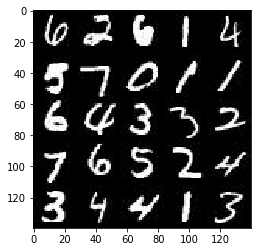

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

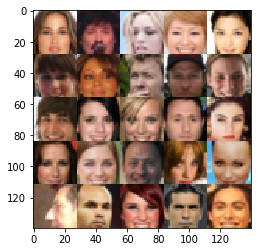

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_shape = (None, image_width, image_height, image_channels)
    real_inps = tf.placeholder(dtype=tf.float32, shape= real_shape, name="real_inputs")
    z_inps = tf.placeholder(dtype=tf.float32, shape=(None, z_dim), name="z_inputs")
    lr = tf.placeholder(dtype=tf.float32, shape=(None), name="learning_rate")

    return real_inps, z_inps, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    # Reference: https://github.com/udacity/deep-learning/blob/master/dcgan-svhn/DCGAN.ipynb

    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64

        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128

        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse = not is_train
    alpha = 0.2
    with tf.variable_scope('generator', reuse=reuse):
        # Firsh fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 3, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x128 now
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x64 now
        
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28xout_channel_dim now
        
        out = tf.tanh(logits)
        
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    gen_model = generator(input_z, out_channel_dim)
    dis_model_real,     dis_logits_real = discriminator(input_real)
    dis_model_fake,     dis_logits_fake = discriminator(gen_model, reuse=True)
    
    dis_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=dis_logits_real, labels=tf.ones_like(dis_model_real)
        )
    )
    dis_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=dis_logits_fake, labels=tf.zeros_like(dis_model_fake)
        )
    )
    gen_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=dis_logits_fake, labels=tf.ones_like(dis_model_fake)
        )
    )
    
    dis_loss = dis_loss_real + dis_loss_fake
    
    return dis_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    dis_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        gen_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    
    return dis_train_opt, gen_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    n_samples, width, height, channels = data_shape
    input_real, input_z, learn_rate = model_inputs(width, height, channels, z_dim)
    dis_loss, gen_loss = model_loss(input_real, input_z, channels)
    dis_opt, gen_opt = model_opt(dis_loss, gen_loss, learn_rate, beta1)
    
    steps = 0
    show_every = 50
    print_every = 10
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images = batch_images * 2
                # TODO: Train Model
                steps += 1

                z_batch = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(dis_opt, feed_dict={input_real: batch_images, input_z: z_batch, learn_rate: learning_rate})
                _ = sess.run(gen_opt, feed_dict={input_real: batch_images, input_z: z_batch, learn_rate: learning_rate})

                if steps % show_every == 0:
                    n_images = 16
                    show_generator_output(sess, n_images, input_z, channels, data_image_mode)

                if steps % print_every == 0:
                    train_loss_dis = dis_loss.eval({input_z: z_batch, input_real: batch_images})
                    train_loss_gen = gen_loss.eval({input_z: z_batch})

                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_dis),
                          "Generator Loss: {:.4f}".format(train_loss_gen))
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... Discriminator Loss: 6.0058... Generator Loss: 0.0073
Epoch 0/2... Discriminator Loss: 3.2152... Generator Loss: 0.3383
Epoch 0/2... Discriminator Loss: 1.1820... Generator Loss: 2.5231
Epoch 0/2... Discriminator Loss: 1.4486... Generator Loss: 0.4725


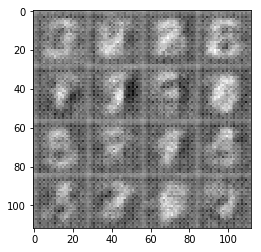

Epoch 0/2... Discriminator Loss: 1.7867... Generator Loss: 4.0928
Epoch 0/2... Discriminator Loss: 2.1895... Generator Loss: 0.1745
Epoch 0/2... Discriminator Loss: 0.7887... Generator Loss: 1.3179
Epoch 0/2... Discriminator Loss: 0.7087... Generator Loss: 1.6176
Epoch 0/2... Discriminator Loss: 0.9537... Generator Loss: 0.6801


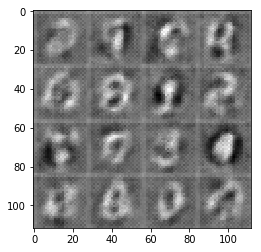

Epoch 0/2... Discriminator Loss: 0.9893... Generator Loss: 0.6904
Epoch 0/2... Discriminator Loss: 0.8852... Generator Loss: 0.9608
Epoch 0/2... Discriminator Loss: 0.8409... Generator Loss: 2.2874
Epoch 0/2... Discriminator Loss: 0.7023... Generator Loss: 1.8002
Epoch 0/2... Discriminator Loss: 0.6528... Generator Loss: 1.9224


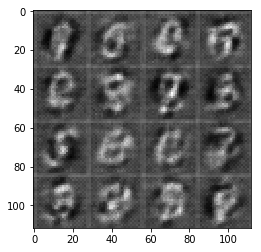

Epoch 0/2... Discriminator Loss: 0.7324... Generator Loss: 1.8062
Epoch 0/2... Discriminator Loss: 1.2149... Generator Loss: 0.6501
Epoch 0/2... Discriminator Loss: 1.0452... Generator Loss: 0.5867
Epoch 0/2... Discriminator Loss: 0.5852... Generator Loss: 1.2185
Epoch 0/2... Discriminator Loss: 0.7083... Generator Loss: 1.1202


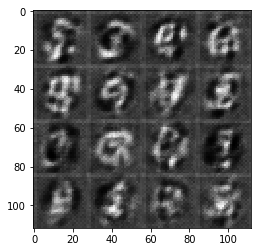

Epoch 0/2... Discriminator Loss: 0.6096... Generator Loss: 1.8059
Epoch 0/2... Discriminator Loss: 0.6486... Generator Loss: 1.0719
Epoch 0/2... Discriminator Loss: 0.5922... Generator Loss: 1.6816
Epoch 0/2... Discriminator Loss: 0.8401... Generator Loss: 0.7367
Epoch 0/2... Discriminator Loss: 0.4423... Generator Loss: 1.6208


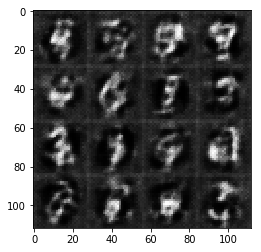

Epoch 0/2... Discriminator Loss: 0.4848... Generator Loss: 1.4484
Epoch 0/2... Discriminator Loss: 0.3935... Generator Loss: 1.7580
Epoch 0/2... Discriminator Loss: 0.5559... Generator Loss: 1.1822
Epoch 0/2... Discriminator Loss: 0.4132... Generator Loss: 1.9047
Epoch 0/2... Discriminator Loss: 1.1816... Generator Loss: 0.5059


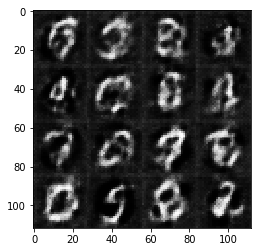

Epoch 0/2... Discriminator Loss: 0.3896... Generator Loss: 1.6703
Epoch 0/2... Discriminator Loss: 0.5820... Generator Loss: 1.1925
Epoch 0/2... Discriminator Loss: 0.4647... Generator Loss: 1.6401
Epoch 0/2... Discriminator Loss: 0.8498... Generator Loss: 0.7284
Epoch 0/2... Discriminator Loss: 1.1819... Generator Loss: 4.9164


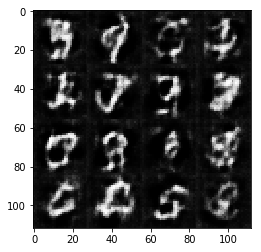

Epoch 0/2... Discriminator Loss: 0.9113... Generator Loss: 0.7057
Epoch 0/2... Discriminator Loss: 0.3983... Generator Loss: 2.1003
Epoch 0/2... Discriminator Loss: 0.5999... Generator Loss: 1.0452
Epoch 0/2... Discriminator Loss: 0.4469... Generator Loss: 2.4015
Epoch 0/2... Discriminator Loss: 0.7621... Generator Loss: 0.8163


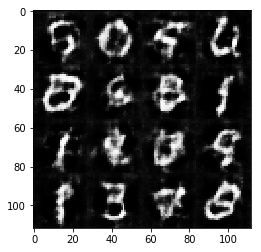

Epoch 0/2... Discriminator Loss: 0.9903... Generator Loss: 0.6298
Epoch 0/2... Discriminator Loss: 0.6047... Generator Loss: 1.2807
Epoch 0/2... Discriminator Loss: 0.5673... Generator Loss: 1.3946
Epoch 0/2... Discriminator Loss: 0.7656... Generator Loss: 0.8195
Epoch 0/2... Discriminator Loss: 0.3768... Generator Loss: 1.8655


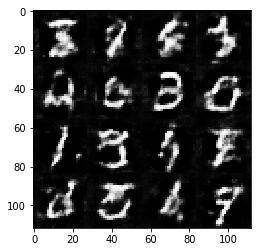

Epoch 0/2... Discriminator Loss: 0.7148... Generator Loss: 0.9334
Epoch 0/2... Discriminator Loss: 2.3754... Generator Loss: 0.1737
Epoch 0/2... Discriminator Loss: 1.1249... Generator Loss: 0.5396
Epoch 0/2... Discriminator Loss: 0.4192... Generator Loss: 1.5796
Epoch 0/2... Discriminator Loss: 0.9394... Generator Loss: 3.0765


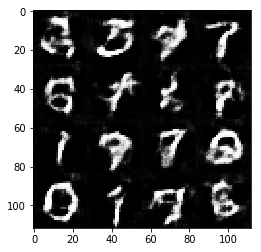

Epoch 0/2... Discriminator Loss: 0.4878... Generator Loss: 1.5475
Epoch 0/2... Discriminator Loss: 0.9634... Generator Loss: 0.6640
Epoch 0/2... Discriminator Loss: 0.4291... Generator Loss: 1.8226
Epoch 0/2... Discriminator Loss: 0.4649... Generator Loss: 1.8058
Epoch 0/2... Discriminator Loss: 1.4392... Generator Loss: 0.3435


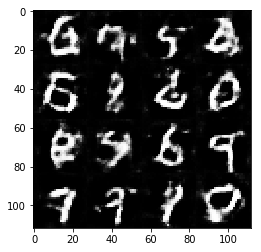

Epoch 0/2... Discriminator Loss: 0.6436... Generator Loss: 0.9489
Epoch 0/2... Discriminator Loss: 0.7128... Generator Loss: 2.5216
Epoch 0/2... Discriminator Loss: 0.4314... Generator Loss: 2.1705
Epoch 0/2... Discriminator Loss: 0.5886... Generator Loss: 1.3650
Epoch 0/2... Discriminator Loss: 0.5181... Generator Loss: 2.1506


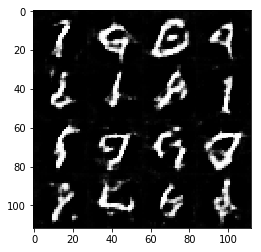

Epoch 0/2... Discriminator Loss: 0.6335... Generator Loss: 1.1933
Epoch 0/2... Discriminator Loss: 0.5420... Generator Loss: 1.8979
Epoch 0/2... Discriminator Loss: 0.5202... Generator Loss: 2.1516
Epoch 0/2... Discriminator Loss: 0.6747... Generator Loss: 0.9661
Epoch 0/2... Discriminator Loss: 1.1301... Generator Loss: 0.5765


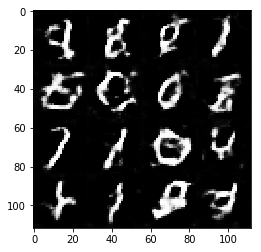

Epoch 0/2... Discriminator Loss: 0.7326... Generator Loss: 0.9096
Epoch 0/2... Discriminator Loss: 0.5959... Generator Loss: 1.3040
Epoch 0/2... Discriminator Loss: 0.4616... Generator Loss: 1.6990
Epoch 0/2... Discriminator Loss: 2.2002... Generator Loss: 0.1986
Epoch 0/2... Discriminator Loss: 1.5414... Generator Loss: 4.0544


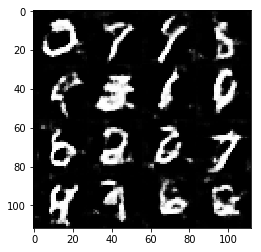

Epoch 0/2... Discriminator Loss: 0.7974... Generator Loss: 0.8578
Epoch 0/2... Discriminator Loss: 0.8479... Generator Loss: 0.7149
Epoch 0/2... Discriminator Loss: 0.4068... Generator Loss: 2.2110
Epoch 0/2... Discriminator Loss: 0.5176... Generator Loss: 1.9351
Epoch 0/2... Discriminator Loss: 0.6702... Generator Loss: 0.9137


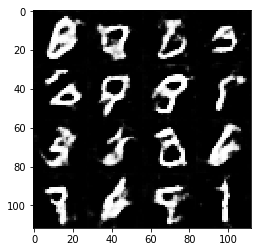

Epoch 0/2... Discriminator Loss: 0.7054... Generator Loss: 1.0239
Epoch 0/2... Discriminator Loss: 0.5701... Generator Loss: 1.6515
Epoch 0/2... Discriminator Loss: 0.6950... Generator Loss: 1.0299
Epoch 0/2... Discriminator Loss: 0.5647... Generator Loss: 1.2141
Epoch 0/2... Discriminator Loss: 0.9368... Generator Loss: 2.4601


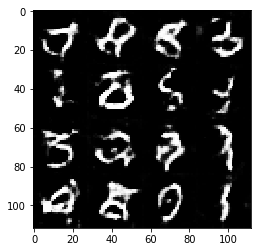

Epoch 0/2... Discriminator Loss: 0.6688... Generator Loss: 0.9718
Epoch 0/2... Discriminator Loss: 0.5538... Generator Loss: 1.3896
Epoch 0/2... Discriminator Loss: 0.4636... Generator Loss: 1.3739
Epoch 0/2... Discriminator Loss: 0.7065... Generator Loss: 0.9538
Epoch 0/2... Discriminator Loss: 0.4296... Generator Loss: 2.2053


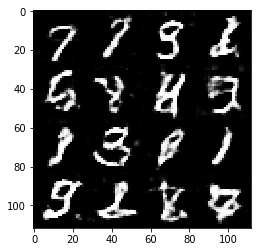

Epoch 0/2... Discriminator Loss: 0.4282... Generator Loss: 2.9260
Epoch 0/2... Discriminator Loss: 0.5673... Generator Loss: 1.2269
Epoch 0/2... Discriminator Loss: 0.5565... Generator Loss: 1.2097
Epoch 0/2... Discriminator Loss: 1.1487... Generator Loss: 0.5418
Epoch 0/2... Discriminator Loss: 0.6111... Generator Loss: 2.5527


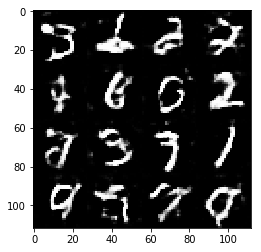

Epoch 0/2... Discriminator Loss: 0.8555... Generator Loss: 0.7885
Epoch 0/2... Discriminator Loss: 0.4587... Generator Loss: 1.7531
Epoch 0/2... Discriminator Loss: 0.5175... Generator Loss: 1.1665
Epoch 0/2... Discriminator Loss: 0.6932... Generator Loss: 0.8640
Epoch 1/2... Discriminator Loss: 0.9430... Generator Loss: 0.6686


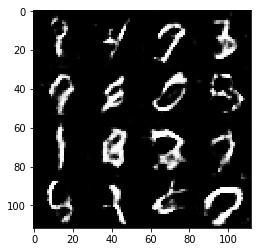

Epoch 1/2... Discriminator Loss: 1.9504... Generator Loss: 3.4756
Epoch 1/2... Discriminator Loss: 0.7037... Generator Loss: 1.6868
Epoch 1/2... Discriminator Loss: 0.5708... Generator Loss: 1.4699
Epoch 1/2... Discriminator Loss: 0.5378... Generator Loss: 1.3631
Epoch 1/2... Discriminator Loss: 0.6594... Generator Loss: 1.0115


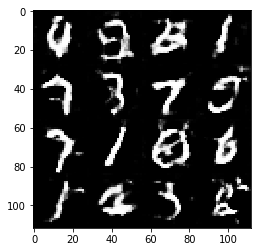

Epoch 1/2... Discriminator Loss: 0.4296... Generator Loss: 1.5118
Epoch 1/2... Discriminator Loss: 0.4483... Generator Loss: 1.5429
Epoch 1/2... Discriminator Loss: 0.4795... Generator Loss: 1.2232
Epoch 1/2... Discriminator Loss: 0.4878... Generator Loss: 1.2699
Epoch 1/2... Discriminator Loss: 0.4287... Generator Loss: 1.5452


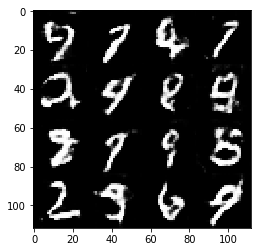

Epoch 1/2... Discriminator Loss: 0.4442... Generator Loss: 1.3293
Epoch 1/2... Discriminator Loss: 0.5255... Generator Loss: 1.2093
Epoch 1/2... Discriminator Loss: 0.4734... Generator Loss: 1.3415
Epoch 1/2... Discriminator Loss: 0.6147... Generator Loss: 1.0986
Epoch 1/2... Discriminator Loss: 0.3527... Generator Loss: 1.5418


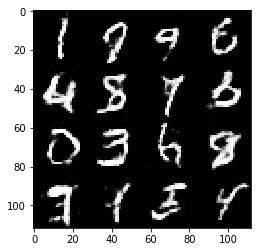

Epoch 1/2... Discriminator Loss: 9.2354... Generator Loss: 11.9524
Epoch 1/2... Discriminator Loss: 0.7581... Generator Loss: 1.0902
Epoch 1/2... Discriminator Loss: 0.8049... Generator Loss: 0.9904
Epoch 1/2... Discriminator Loss: 0.5638... Generator Loss: 1.5364
Epoch 1/2... Discriminator Loss: 0.4450... Generator Loss: 1.5400


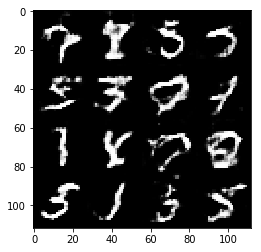

Epoch 1/2... Discriminator Loss: 0.3579... Generator Loss: 1.6882
Epoch 1/2... Discriminator Loss: 0.4677... Generator Loss: 1.2906
Epoch 1/2... Discriminator Loss: 0.5549... Generator Loss: 1.1945
Epoch 1/2... Discriminator Loss: 0.5491... Generator Loss: 1.3891
Epoch 1/2... Discriminator Loss: 0.4222... Generator Loss: 1.8628


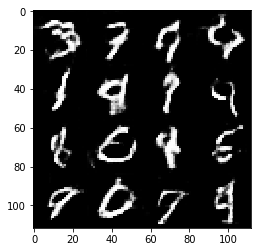

Epoch 1/2... Discriminator Loss: 0.4286... Generator Loss: 1.4934
Epoch 1/2... Discriminator Loss: 0.5500... Generator Loss: 1.0795
Epoch 1/2... Discriminator Loss: 0.7472... Generator Loss: 0.9299
Epoch 1/2... Discriminator Loss: 0.4881... Generator Loss: 1.1683
Epoch 1/2... Discriminator Loss: 1.9687... Generator Loss: 0.2788


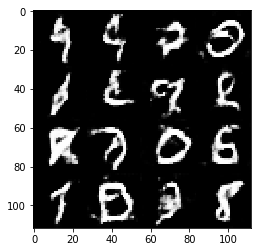

Epoch 1/2... Discriminator Loss: 0.9740... Generator Loss: 0.7926
Epoch 1/2... Discriminator Loss: 0.9355... Generator Loss: 0.6985
Epoch 1/2... Discriminator Loss: 0.6329... Generator Loss: 1.4419
Epoch 1/2... Discriminator Loss: 0.6130... Generator Loss: 1.4324
Epoch 1/2... Discriminator Loss: 0.6228... Generator Loss: 1.1773


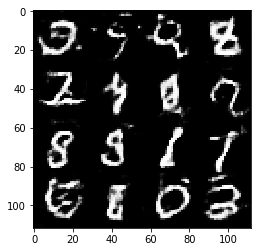

Epoch 1/2... Discriminator Loss: 0.6417... Generator Loss: 1.2235
Epoch 1/2... Discriminator Loss: 0.6119... Generator Loss: 1.1341
Epoch 1/2... Discriminator Loss: 0.6443... Generator Loss: 1.1232
Epoch 1/2... Discriminator Loss: 0.5371... Generator Loss: 1.3086
Epoch 1/2... Discriminator Loss: 1.3108... Generator Loss: 0.4389


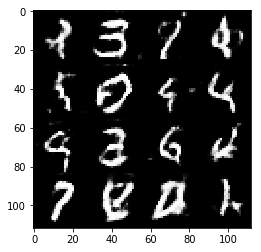

Epoch 1/2... Discriminator Loss: 0.5964... Generator Loss: 1.2318
Epoch 1/2... Discriminator Loss: 0.7055... Generator Loss: 0.8554
Epoch 1/2... Discriminator Loss: 0.5417... Generator Loss: 1.1601
Epoch 1/2... Discriminator Loss: 1.3351... Generator Loss: 0.8736
Epoch 1/2... Discriminator Loss: 0.9529... Generator Loss: 0.6530


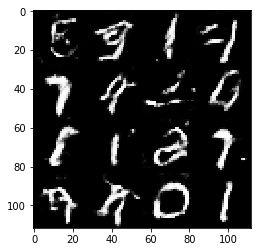

Epoch 1/2... Discriminator Loss: 0.6273... Generator Loss: 1.3668
Epoch 1/2... Discriminator Loss: 0.6425... Generator Loss: 1.0531
Epoch 1/2... Discriminator Loss: 0.7372... Generator Loss: 0.8777
Epoch 1/2... Discriminator Loss: 0.4691... Generator Loss: 1.4616
Epoch 1/2... Discriminator Loss: 0.5893... Generator Loss: 1.2423


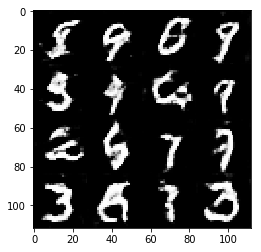

Epoch 1/2... Discriminator Loss: 1.3015... Generator Loss: 0.4923
Epoch 1/2... Discriminator Loss: 0.9450... Generator Loss: 0.8025
Epoch 1/2... Discriminator Loss: 0.8105... Generator Loss: 0.8179
Epoch 1/2... Discriminator Loss: 0.5719... Generator Loss: 1.2769
Epoch 1/2... Discriminator Loss: 0.7189... Generator Loss: 0.9338


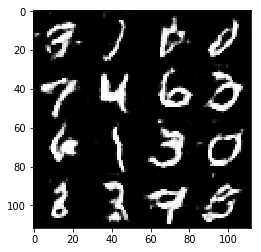

Epoch 1/2... Discriminator Loss: 1.2682... Generator Loss: 0.5329
Epoch 1/2... Discriminator Loss: 0.6265... Generator Loss: 1.0548
Epoch 1/2... Discriminator Loss: 1.0376... Generator Loss: 0.5940
Epoch 1/2... Discriminator Loss: 0.6267... Generator Loss: 1.3288
Epoch 1/2... Discriminator Loss: 0.5518... Generator Loss: 1.4497


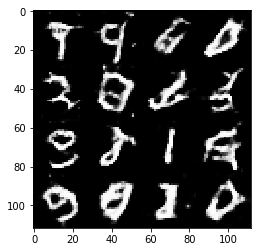

Epoch 1/2... Discriminator Loss: 0.5245... Generator Loss: 1.3404
Epoch 1/2... Discriminator Loss: 0.4873... Generator Loss: 1.3556
Epoch 1/2... Discriminator Loss: 0.6040... Generator Loss: 1.5848
Epoch 1/2... Discriminator Loss: 0.7081... Generator Loss: 3.4423
Epoch 1/2... Discriminator Loss: 0.5708... Generator Loss: 1.2527


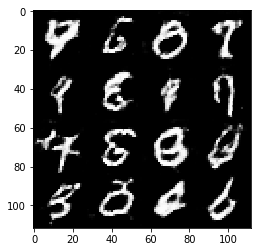

Epoch 1/2... Discriminator Loss: 0.3724... Generator Loss: 1.7349
Epoch 1/2... Discriminator Loss: 1.3618... Generator Loss: 0.4578
Epoch 1/2... Discriminator Loss: 1.2064... Generator Loss: 0.6611
Epoch 1/2... Discriminator Loss: 0.5729... Generator Loss: 1.1753
Epoch 1/2... Discriminator Loss: 0.5125... Generator Loss: 1.5030


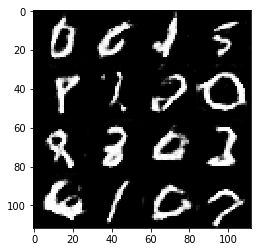

Epoch 1/2... Discriminator Loss: 0.6216... Generator Loss: 1.1159
Epoch 1/2... Discriminator Loss: 0.5104... Generator Loss: 1.2696
Epoch 1/2... Discriminator Loss: 0.5235... Generator Loss: 1.2176
Epoch 1/2... Discriminator Loss: 0.8426... Generator Loss: 0.7690
Epoch 1/2... Discriminator Loss: 0.6413... Generator Loss: 1.0357


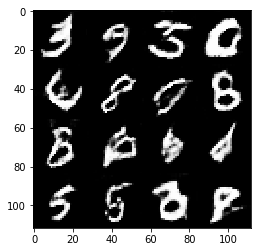

Epoch 1/2... Discriminator Loss: 0.9210... Generator Loss: 0.7369
Epoch 1/2... Discriminator Loss: 0.6907... Generator Loss: 1.0293
Epoch 1/2... Discriminator Loss: 0.6994... Generator Loss: 0.9483
Epoch 1/2... Discriminator Loss: 0.4262... Generator Loss: 1.3622
Epoch 1/2... Discriminator Loss: 0.9356... Generator Loss: 0.7186


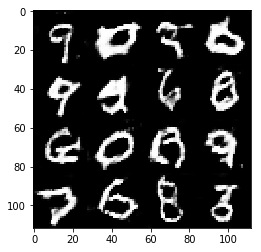

Epoch 1/2... Discriminator Loss: 0.4419... Generator Loss: 1.3886
Epoch 1/2... Discriminator Loss: 2.0766... Generator Loss: 0.2548
Epoch 1/2... Discriminator Loss: 0.7167... Generator Loss: 0.9170
Epoch 1/2... Discriminator Loss: 0.4377... Generator Loss: 1.7064
Epoch 1/2... Discriminator Loss: 1.6124... Generator Loss: 0.3076


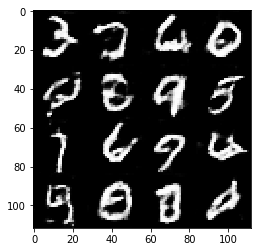

Epoch 1/2... Discriminator Loss: 0.5218... Generator Loss: 1.4080
Epoch 1/2... Discriminator Loss: 0.6272... Generator Loss: 1.0555
Epoch 1/2... Discriminator Loss: 0.8497... Generator Loss: 0.8202
Epoch 1/2... Discriminator Loss: 0.3087... Generator Loss: 2.0907
Epoch 1/2... Discriminator Loss: 0.4353... Generator Loss: 1.4517


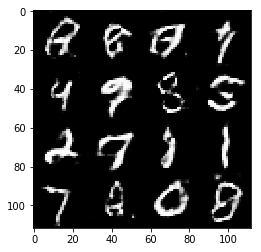

Epoch 1/2... Discriminator Loss: 0.5857... Generator Loss: 1.2961
Epoch 1/2... Discriminator Loss: 0.6329... Generator Loss: 1.0719
Epoch 1/2... Discriminator Loss: 0.9757... Generator Loss: 0.6431


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1... Discriminator Loss: 0.0716... Generator Loss: 3.5078
Epoch 0/1... Discriminator Loss: 1.9654... Generator Loss: 13.7455
Epoch 0/1... Discriminator Loss: 0.1959... Generator Loss: 3.9745
Epoch 0/1... Discriminator Loss: 0.8374... Generator Loss: 1.3843


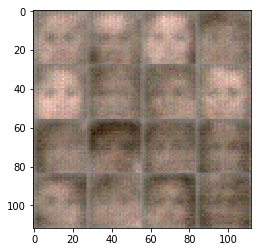

Epoch 0/1... Discriminator Loss: 1.0923... Generator Loss: 4.3865
Epoch 0/1... Discriminator Loss: 0.5264... Generator Loss: 1.7131
Epoch 0/1... Discriminator Loss: 0.4602... Generator Loss: 1.7178
Epoch 0/1... Discriminator Loss: 0.4469... Generator Loss: 2.1552
Epoch 0/1... Discriminator Loss: 3.6735... Generator Loss: 7.8786


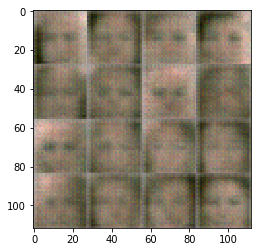

Epoch 0/1... Discriminator Loss: 0.6056... Generator Loss: 1.4637
Epoch 0/1... Discriminator Loss: 0.5643... Generator Loss: 1.3656
Epoch 0/1... Discriminator Loss: 0.5112... Generator Loss: 2.9064
Epoch 0/1... Discriminator Loss: 0.6975... Generator Loss: 1.2976
Epoch 0/1... Discriminator Loss: 1.2086... Generator Loss: 0.6502


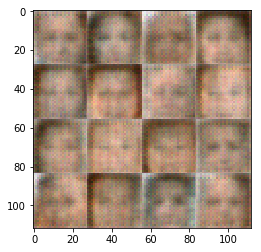

Epoch 0/1... Discriminator Loss: 1.2431... Generator Loss: 3.0664
Epoch 0/1... Discriminator Loss: 0.8752... Generator Loss: 1.1730
Epoch 0/1... Discriminator Loss: 0.6973... Generator Loss: 2.5637
Epoch 0/1... Discriminator Loss: 0.6855... Generator Loss: 1.1959
Epoch 0/1... Discriminator Loss: 0.8784... Generator Loss: 0.7595


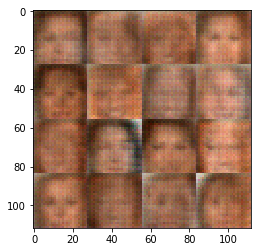

Epoch 0/1... Discriminator Loss: 1.7927... Generator Loss: 2.0446
Epoch 0/1... Discriminator Loss: 1.2676... Generator Loss: 2.3379
Epoch 0/1... Discriminator Loss: 2.0842... Generator Loss: 3.9122
Epoch 0/1... Discriminator Loss: 1.0431... Generator Loss: 0.5728
Epoch 0/1... Discriminator Loss: 0.7209... Generator Loss: 1.4165


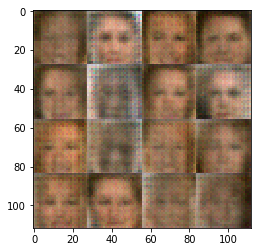

Epoch 0/1... Discriminator Loss: 0.9547... Generator Loss: 1.4065
Epoch 0/1... Discriminator Loss: 0.7574... Generator Loss: 1.0938
Epoch 0/1... Discriminator Loss: 0.9699... Generator Loss: 0.8756
Epoch 0/1... Discriminator Loss: 1.5482... Generator Loss: 0.3416
Epoch 0/1... Discriminator Loss: 1.2528... Generator Loss: 0.5258


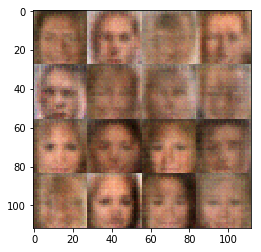

Epoch 0/1... Discriminator Loss: 0.9467... Generator Loss: 2.2792
Epoch 0/1... Discriminator Loss: 0.6908... Generator Loss: 2.0986
Epoch 0/1... Discriminator Loss: 1.6749... Generator Loss: 2.3555
Epoch 0/1... Discriminator Loss: 1.2332... Generator Loss: 0.7151
Epoch 0/1... Discriminator Loss: 1.4790... Generator Loss: 0.3790


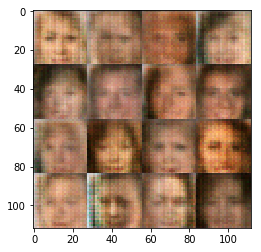

Epoch 0/1... Discriminator Loss: 1.2264... Generator Loss: 0.4839
Epoch 0/1... Discriminator Loss: 1.2899... Generator Loss: 0.5202
Epoch 0/1... Discriminator Loss: 1.0568... Generator Loss: 0.8967
Epoch 0/1... Discriminator Loss: 1.4939... Generator Loss: 1.2358
Epoch 0/1... Discriminator Loss: 1.0723... Generator Loss: 0.8485


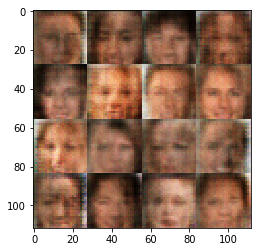

Epoch 0/1... Discriminator Loss: 1.2823... Generator Loss: 0.5796
Epoch 0/1... Discriminator Loss: 1.1158... Generator Loss: 0.7735
Epoch 0/1... Discriminator Loss: 0.8717... Generator Loss: 0.9167
Epoch 0/1... Discriminator Loss: 1.0496... Generator Loss: 1.1900
Epoch 0/1... Discriminator Loss: 1.1996... Generator Loss: 0.9532


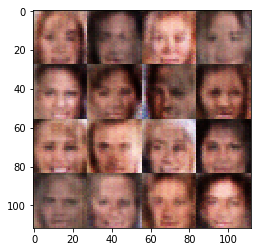

Epoch 0/1... Discriminator Loss: 1.2840... Generator Loss: 0.5514
Epoch 0/1... Discriminator Loss: 1.1489... Generator Loss: 0.6772
Epoch 0/1... Discriminator Loss: 1.0788... Generator Loss: 0.6569
Epoch 0/1... Discriminator Loss: 1.0491... Generator Loss: 0.7630
Epoch 0/1... Discriminator Loss: 1.1350... Generator Loss: 0.7652


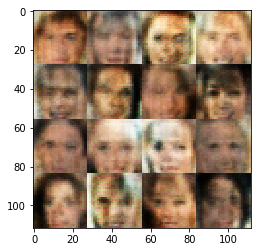

Epoch 0/1... Discriminator Loss: 1.2436... Generator Loss: 0.5052
Epoch 0/1... Discriminator Loss: 1.5179... Generator Loss: 0.3250
Epoch 0/1... Discriminator Loss: 1.3570... Generator Loss: 0.4658
Epoch 0/1... Discriminator Loss: 1.6121... Generator Loss: 2.0391
Epoch 0/1... Discriminator Loss: 1.2755... Generator Loss: 0.7632


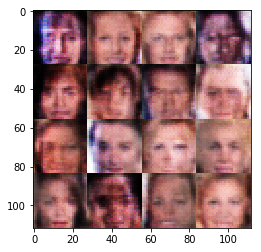

Epoch 0/1... Discriminator Loss: 0.8513... Generator Loss: 1.3804
Epoch 0/1... Discriminator Loss: 0.7472... Generator Loss: 1.3355
Epoch 0/1... Discriminator Loss: 1.1493... Generator Loss: 1.1432
Epoch 0/1... Discriminator Loss: 1.1961... Generator Loss: 1.0656
Epoch 0/1... Discriminator Loss: 1.8685... Generator Loss: 1.8454


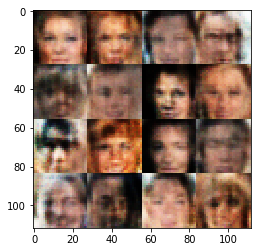

Epoch 0/1... Discriminator Loss: 0.9962... Generator Loss: 0.7959
Epoch 0/1... Discriminator Loss: 0.5670... Generator Loss: 1.3489
Epoch 0/1... Discriminator Loss: 0.8489... Generator Loss: 0.7246
Epoch 0/1... Discriminator Loss: 1.7537... Generator Loss: 0.2773
Epoch 0/1... Discriminator Loss: 1.0129... Generator Loss: 0.7357


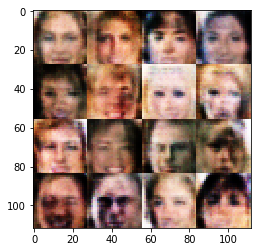

Epoch 0/1... Discriminator Loss: 0.7898... Generator Loss: 0.8370
Epoch 0/1... Discriminator Loss: 0.7228... Generator Loss: 1.7408
Epoch 0/1... Discriminator Loss: 1.3187... Generator Loss: 0.4393
Epoch 0/1... Discriminator Loss: 1.0145... Generator Loss: 1.8615
Epoch 0/1... Discriminator Loss: 0.3554... Generator Loss: 3.1716


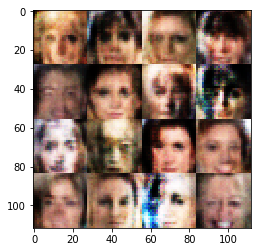

Epoch 0/1... Discriminator Loss: 0.4186... Generator Loss: 2.1259
Epoch 0/1... Discriminator Loss: 1.0228... Generator Loss: 1.9677
Epoch 0/1... Discriminator Loss: 0.3732... Generator Loss: 3.6656
Epoch 0/1... Discriminator Loss: 0.5643... Generator Loss: 1.0857
Epoch 0/1... Discriminator Loss: 1.0039... Generator Loss: 0.6045


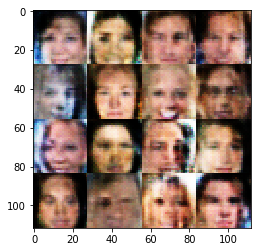

Epoch 0/1... Discriminator Loss: 1.9082... Generator Loss: 0.2451
Epoch 0/1... Discriminator Loss: 0.2455... Generator Loss: 2.5237
Epoch 0/1... Discriminator Loss: 1.1033... Generator Loss: 0.5239
Epoch 0/1... Discriminator Loss: 0.2575... Generator Loss: 2.0367
Epoch 0/1... Discriminator Loss: 0.5276... Generator Loss: 1.1374


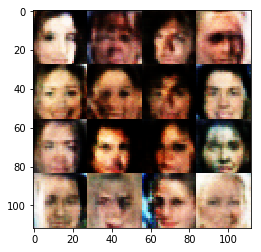

Epoch 0/1... Discriminator Loss: 0.3023... Generator Loss: 1.7363
Epoch 0/1... Discriminator Loss: 0.3425... Generator Loss: 1.8331
Epoch 0/1... Discriminator Loss: 1.0645... Generator Loss: 6.6179
Epoch 0/1... Discriminator Loss: 1.5739... Generator Loss: 0.3064
Epoch 0/1... Discriminator Loss: 1.0921... Generator Loss: 0.5333


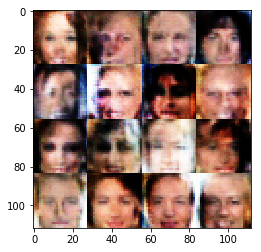

Epoch 0/1... Discriminator Loss: 0.2382... Generator Loss: 2.4021
Epoch 0/1... Discriminator Loss: 0.8822... Generator Loss: 0.8378
Epoch 0/1... Discriminator Loss: 0.9215... Generator Loss: 0.7000
Epoch 0/1... Discriminator Loss: 0.1546... Generator Loss: 4.6171
Epoch 0/1... Discriminator Loss: 0.2347... Generator Loss: 2.2816


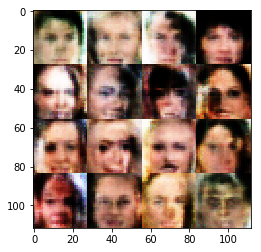

Epoch 0/1... Discriminator Loss: 0.9258... Generator Loss: 0.6213
Epoch 0/1... Discriminator Loss: 0.1802... Generator Loss: 2.4109
Epoch 0/1... Discriminator Loss: 0.0762... Generator Loss: 4.7722
Epoch 0/1... Discriminator Loss: 0.7279... Generator Loss: 0.8671
Epoch 0/1... Discriminator Loss: 1.3601... Generator Loss: 1.4911


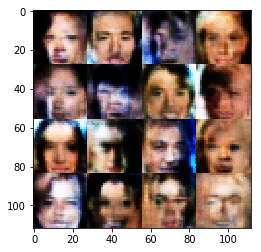

Epoch 0/1... Discriminator Loss: 0.6378... Generator Loss: 3.0072
Epoch 0/1... Discriminator Loss: 0.5260... Generator Loss: 3.9455
Epoch 0/1... Discriminator Loss: 0.3685... Generator Loss: 1.5899
Epoch 0/1... Discriminator Loss: 0.2251... Generator Loss: 1.9956
Epoch 0/1... Discriminator Loss: 0.3858... Generator Loss: 3.4852


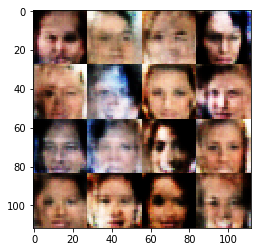

Epoch 0/1... Discriminator Loss: 0.4052... Generator Loss: 1.3475
Epoch 0/1... Discriminator Loss: 1.6078... Generator Loss: 0.2623
Epoch 0/1... Discriminator Loss: 0.2277... Generator Loss: 2.1736
Epoch 0/1... Discriminator Loss: 0.0904... Generator Loss: 3.1033
Epoch 0/1... Discriminator Loss: 0.2210... Generator Loss: 5.4616


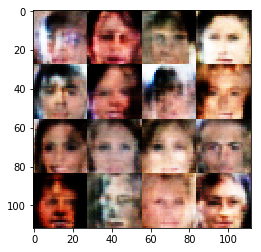

Epoch 0/1... Discriminator Loss: 0.1675... Generator Loss: 4.1068
Epoch 0/1... Discriminator Loss: 0.1254... Generator Loss: 2.9462
Epoch 0/1... Discriminator Loss: 0.4789... Generator Loss: 1.2145
Epoch 0/1... Discriminator Loss: 0.8617... Generator Loss: 0.7625
Epoch 0/1... Discriminator Loss: 0.0472... Generator Loss: 5.7073


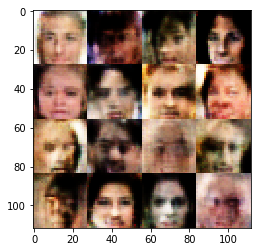

Epoch 0/1... Discriminator Loss: 0.3302... Generator Loss: 1.9016
Epoch 0/1... Discriminator Loss: 0.1895... Generator Loss: 2.3605
Epoch 0/1... Discriminator Loss: 1.4364... Generator Loss: 1.3269
Epoch 0/1... Discriminator Loss: 1.2708... Generator Loss: 0.7979
Epoch 0/1... Discriminator Loss: 1.2795... Generator Loss: 0.5198


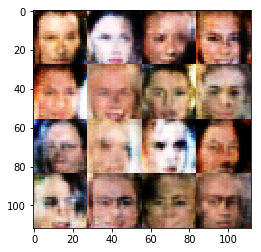

Epoch 0/1... Discriminator Loss: 1.0516... Generator Loss: 0.7418
Epoch 0/1... Discriminator Loss: 1.1848... Generator Loss: 0.6054
Epoch 0/1... Discriminator Loss: 0.9414... Generator Loss: 0.8021
Epoch 0/1... Discriminator Loss: 0.9882... Generator Loss: 0.9637
Epoch 0/1... Discriminator Loss: 0.8635... Generator Loss: 0.9082


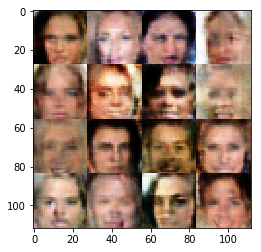

Epoch 0/1... Discriminator Loss: 0.9812... Generator Loss: 0.7642
Epoch 0/1... Discriminator Loss: 0.8228... Generator Loss: 1.5969
Epoch 0/1... Discriminator Loss: 0.9980... Generator Loss: 1.5378
Epoch 0/1... Discriminator Loss: 0.7794... Generator Loss: 1.4605
Epoch 0/1... Discriminator Loss: 1.0757... Generator Loss: 1.9231


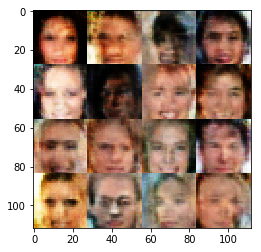

Epoch 0/1... Discriminator Loss: 1.4389... Generator Loss: 0.4162
Epoch 0/1... Discriminator Loss: 1.0398... Generator Loss: 0.6042
Epoch 0/1... Discriminator Loss: 0.8448... Generator Loss: 1.0073
Epoch 0/1... Discriminator Loss: 0.7954... Generator Loss: 1.3673
Epoch 0/1... Discriminator Loss: 0.7345... Generator Loss: 1.5119


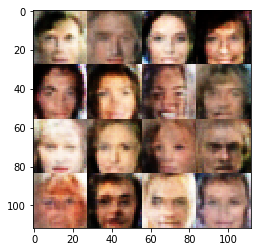

Epoch 0/1... Discriminator Loss: 0.9078... Generator Loss: 0.7905
Epoch 0/1... Discriminator Loss: 1.4410... Generator Loss: 0.3296
Epoch 0/1... Discriminator Loss: 0.7751... Generator Loss: 1.1782
Epoch 0/1... Discriminator Loss: 0.9669... Generator Loss: 1.7435
Epoch 0/1... Discriminator Loss: 0.8546... Generator Loss: 0.8332


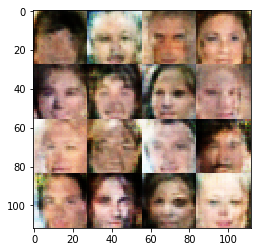

Epoch 0/1... Discriminator Loss: 0.9147... Generator Loss: 0.8753
Epoch 0/1... Discriminator Loss: 0.9478... Generator Loss: 0.7328
Epoch 0/1... Discriminator Loss: 0.8038... Generator Loss: 0.9534
Epoch 0/1... Discriminator Loss: 1.1562... Generator Loss: 0.5378
Epoch 0/1... Discriminator Loss: 0.7777... Generator Loss: 1.6721


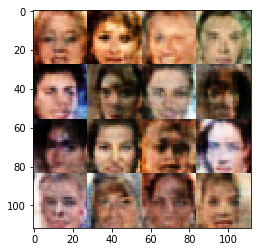

Epoch 0/1... Discriminator Loss: 0.9063... Generator Loss: 2.0261
Epoch 0/1... Discriminator Loss: 0.9278... Generator Loss: 0.7381
Epoch 0/1... Discriminator Loss: 0.9473... Generator Loss: 0.8379
Epoch 0/1... Discriminator Loss: 0.8286... Generator Loss: 1.0627
Epoch 0/1... Discriminator Loss: 0.9316... Generator Loss: 0.6992


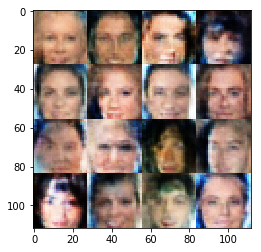

Epoch 0/1... Discriminator Loss: 1.4437... Generator Loss: 0.4017
Epoch 0/1... Discriminator Loss: 0.7673... Generator Loss: 1.1253
Epoch 0/1... Discriminator Loss: 1.1392... Generator Loss: 0.5086
Epoch 0/1... Discriminator Loss: 1.0952... Generator Loss: 0.5588
Epoch 0/1... Discriminator Loss: 1.0104... Generator Loss: 0.6500


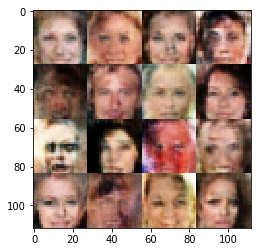

Epoch 0/1... Discriminator Loss: 0.6190... Generator Loss: 1.3416
Epoch 0/1... Discriminator Loss: 0.7354... Generator Loss: 1.4725
Epoch 0/1... Discriminator Loss: 0.7983... Generator Loss: 0.8773
Epoch 0/1... Discriminator Loss: 0.8576... Generator Loss: 2.5989
Epoch 0/1... Discriminator Loss: 0.5257... Generator Loss: 1.6624


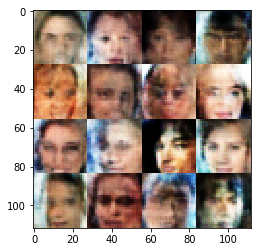

Epoch 0/1... Discriminator Loss: 1.6667... Generator Loss: 0.2762
Epoch 0/1... Discriminator Loss: 0.8988... Generator Loss: 1.4765
Epoch 0/1... Discriminator Loss: 0.9201... Generator Loss: 0.7769
Epoch 0/1... Discriminator Loss: 0.5532... Generator Loss: 1.0737
Epoch 0/1... Discriminator Loss: 1.4480... Generator Loss: 2.3013


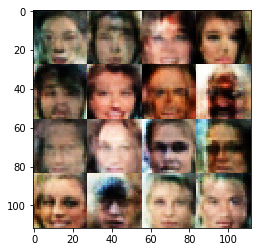

Epoch 0/1... Discriminator Loss: 1.3017... Generator Loss: 0.4416
Epoch 0/1... Discriminator Loss: 1.0966... Generator Loss: 0.5503
Epoch 0/1... Discriminator Loss: 1.3390... Generator Loss: 0.3893
Epoch 0/1... Discriminator Loss: 0.2544... Generator Loss: 2.1860
Epoch 0/1... Discriminator Loss: 0.1392... Generator Loss: 2.7730


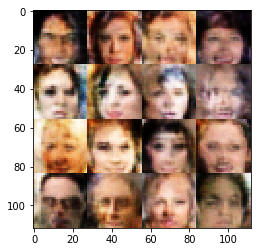

Epoch 0/1... Discriminator Loss: 0.5254... Generator Loss: 1.1675
Epoch 0/1... Discriminator Loss: 0.2844... Generator Loss: 4.0291
Epoch 0/1... Discriminator Loss: 1.8632... Generator Loss: 5.1086
Epoch 0/1... Discriminator Loss: 1.3345... Generator Loss: 1.8716
Epoch 0/1... Discriminator Loss: 0.8218... Generator Loss: 1.8943


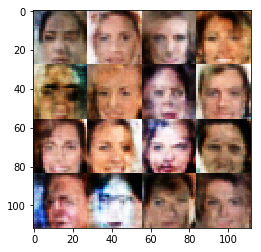

Epoch 0/1... Discriminator Loss: 0.8419... Generator Loss: 0.7941
Epoch 0/1... Discriminator Loss: 1.5351... Generator Loss: 0.3248
Epoch 0/1... Discriminator Loss: 0.2759... Generator Loss: 3.1654
Epoch 0/1... Discriminator Loss: 0.2437... Generator Loss: 1.9480
Epoch 0/1... Discriminator Loss: 0.6044... Generator Loss: 0.9909


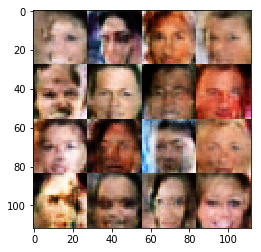

Epoch 0/1... Discriminator Loss: 0.3379... Generator Loss: 2.0913
Epoch 0/1... Discriminator Loss: 0.0892... Generator Loss: 4.8451
Epoch 0/1... Discriminator Loss: 0.4464... Generator Loss: 1.2847
Epoch 0/1... Discriminator Loss: 0.9577... Generator Loss: 1.5732
Epoch 0/1... Discriminator Loss: 0.8758... Generator Loss: 0.8834


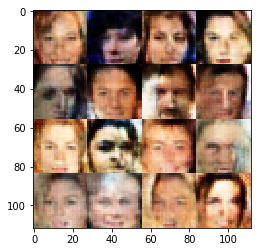

Epoch 0/1... Discriminator Loss: 0.8786... Generator Loss: 1.0872
Epoch 0/1... Discriminator Loss: 0.9754... Generator Loss: 0.7582
Epoch 0/1... Discriminator Loss: 1.0225... Generator Loss: 0.9662
Epoch 0/1... Discriminator Loss: 0.7417... Generator Loss: 1.1677
Epoch 0/1... Discriminator Loss: 1.3094... Generator Loss: 0.3805


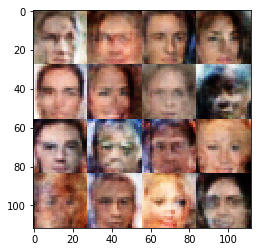

Epoch 0/1... Discriminator Loss: 0.9545... Generator Loss: 0.7976
Epoch 0/1... Discriminator Loss: 0.7402... Generator Loss: 0.8614
Epoch 0/1... Discriminator Loss: 1.1556... Generator Loss: 0.5813
Epoch 0/1... Discriminator Loss: 0.8409... Generator Loss: 0.8119
Epoch 0/1... Discriminator Loss: 0.5103... Generator Loss: 1.4056


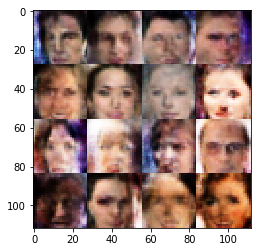

Epoch 0/1... Discriminator Loss: 0.2816... Generator Loss: 2.0351
Epoch 0/1... Discriminator Loss: 2.3621... Generator Loss: 0.1201
Epoch 0/1... Discriminator Loss: 0.9079... Generator Loss: 1.0884
Epoch 0/1... Discriminator Loss: 0.8154... Generator Loss: 3.7436
Epoch 0/1... Discriminator Loss: 0.6071... Generator Loss: 1.8221


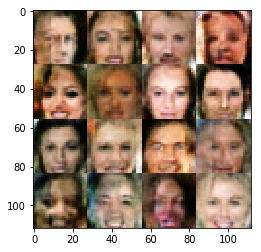

Epoch 0/1... Discriminator Loss: 0.3416... Generator Loss: 1.5952
Epoch 0/1... Discriminator Loss: 0.2164... Generator Loss: 2.0097
Epoch 0/1... Discriminator Loss: 0.1866... Generator Loss: 2.2448
Epoch 0/1... Discriminator Loss: 0.6141... Generator Loss: 0.9116
Epoch 0/1... Discriminator Loss: 0.4471... Generator Loss: 3.4732


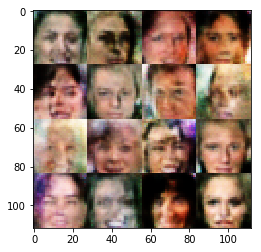

Epoch 0/1... Discriminator Loss: 0.0790... Generator Loss: 3.6685
Epoch 0/1... Discriminator Loss: 0.1839... Generator Loss: 2.4060
Epoch 0/1... Discriminator Loss: 0.2599... Generator Loss: 4.4950
Epoch 0/1... Discriminator Loss: 0.3367... Generator Loss: 3.4537
Epoch 0/1... Discriminator Loss: 0.0465... Generator Loss: 4.4960


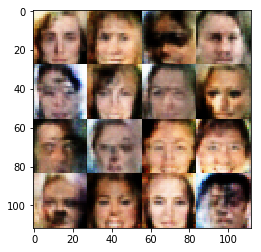

Epoch 0/1... Discriminator Loss: 0.0989... Generator Loss: 7.1889
Epoch 0/1... Discriminator Loss: 0.0507... Generator Loss: 4.7702
Epoch 0/1... Discriminator Loss: 0.9964... Generator Loss: 0.5663
Epoch 0/1... Discriminator Loss: 1.2747... Generator Loss: 0.5533
Epoch 0/1... Discriminator Loss: 0.8771... Generator Loss: 0.7928


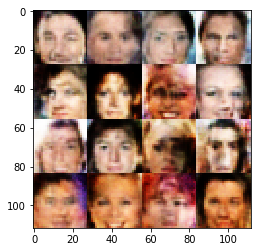

Epoch 0/1... Discriminator Loss: 0.9743... Generator Loss: 0.6741
Epoch 0/1... Discriminator Loss: 0.2427... Generator Loss: 2.2526
Epoch 0/1... Discriminator Loss: 0.3236... Generator Loss: 2.9799
Epoch 0/1... Discriminator Loss: 0.2337... Generator Loss: 2.1744
Epoch 0/1... Discriminator Loss: 0.2177... Generator Loss: 1.9790


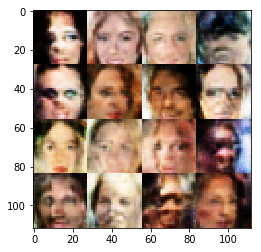

Epoch 0/1... Discriminator Loss: 0.0653... Generator Loss: 4.6453
Epoch 0/1... Discriminator Loss: 0.9661... Generator Loss: 1.0629
Epoch 0/1... Discriminator Loss: 0.7103... Generator Loss: 1.1287
Epoch 0/1... Discriminator Loss: 0.8448... Generator Loss: 1.0593
Epoch 0/1... Discriminator Loss: 2.5293... Generator Loss: 0.1252


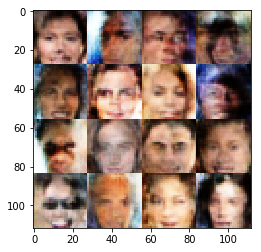

Epoch 0/1... Discriminator Loss: 0.2454... Generator Loss: 4.3036
Epoch 0/1... Discriminator Loss: 0.1665... Generator Loss: 2.7980
Epoch 0/1... Discriminator Loss: 0.1213... Generator Loss: 2.8691
Epoch 0/1... Discriminator Loss: 0.7271... Generator Loss: 0.7807
Epoch 0/1... Discriminator Loss: 2.3876... Generator Loss: 0.1532


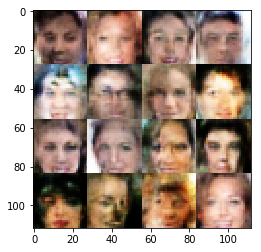

Epoch 0/1... Discriminator Loss: 0.1335... Generator Loss: 3.2141
Epoch 0/1... Discriminator Loss: 0.1364... Generator Loss: 5.2548
Epoch 0/1... Discriminator Loss: 1.0215... Generator Loss: 1.0882
Epoch 0/1... Discriminator Loss: 0.2630... Generator Loss: 3.0935
Epoch 0/1... Discriminator Loss: 0.4081... Generator Loss: 1.3564


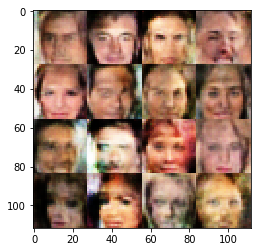

Epoch 0/1... Discriminator Loss: 0.2558... Generator Loss: 1.7645
Epoch 0/1... Discriminator Loss: 1.4555... Generator Loss: 3.7632
Epoch 0/1... Discriminator Loss: 0.0696... Generator Loss: 4.5166
Epoch 0/1... Discriminator Loss: 1.9187... Generator Loss: 0.2025
Epoch 0/1... Discriminator Loss: 0.2616... Generator Loss: 1.9306


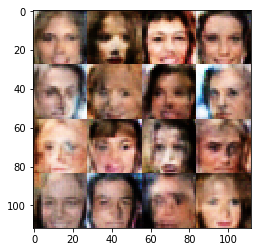

Epoch 0/1... Discriminator Loss: 0.2305... Generator Loss: 2.0735
Epoch 0/1... Discriminator Loss: 0.0490... Generator Loss: 4.3403
Epoch 0/1... Discriminator Loss: 0.0863... Generator Loss: 3.9296
Epoch 0/1... Discriminator Loss: 0.8760... Generator Loss: 0.7219
Epoch 0/1... Discriminator Loss: 0.0556... Generator Loss: 6.8922


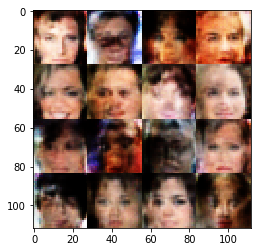

Epoch 0/1... Discriminator Loss: 0.0394... Generator Loss: 4.9103
Epoch 0/1... Discriminator Loss: 0.0751... Generator Loss: 3.8277
Epoch 0/1... Discriminator Loss: 0.1036... Generator Loss: 3.7466
Epoch 0/1... Discriminator Loss: 0.4234... Generator Loss: 4.2887
Epoch 0/1... Discriminator Loss: 1.2592... Generator Loss: 4.2446


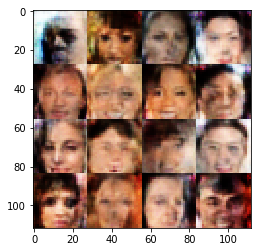

Epoch 0/1... Discriminator Loss: 2.2872... Generator Loss: 0.1675
Epoch 0/1... Discriminator Loss: 0.2721... Generator Loss: 2.3240
Epoch 0/1... Discriminator Loss: 1.3444... Generator Loss: 0.4746
Epoch 0/1... Discriminator Loss: 1.2953... Generator Loss: 0.4411
Epoch 0/1... Discriminator Loss: 0.0733... Generator Loss: 4.1263


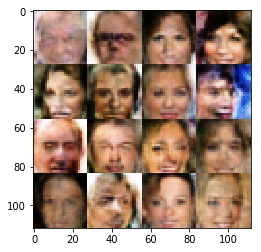

Epoch 0/1... Discriminator Loss: 0.0265... Generator Loss: 6.4233
Epoch 0/1... Discriminator Loss: 0.7273... Generator Loss: 0.8076
Epoch 0/1... Discriminator Loss: 1.0363... Generator Loss: 0.9692
Epoch 0/1... Discriminator Loss: 1.2363... Generator Loss: 1.2981
Epoch 0/1... Discriminator Loss: 1.4450... Generator Loss: 2.6662


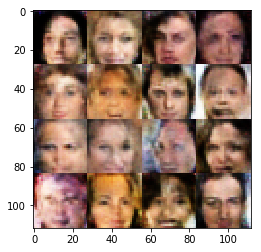

Epoch 0/1... Discriminator Loss: 0.6833... Generator Loss: 1.6385
Epoch 0/1... Discriminator Loss: 0.9150... Generator Loss: 0.6969
Epoch 0/1... Discriminator Loss: 0.5757... Generator Loss: 1.3082
Epoch 0/1... Discriminator Loss: 1.0744... Generator Loss: 0.9581
Epoch 0/1... Discriminator Loss: 1.1097... Generator Loss: 0.5692


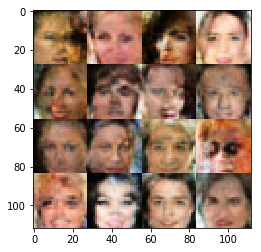

Epoch 0/1... Discriminator Loss: 0.7981... Generator Loss: 1.8583
Epoch 0/1... Discriminator Loss: 0.5758... Generator Loss: 1.1252
Epoch 0/1... Discriminator Loss: 1.8427... Generator Loss: 2.6668
Epoch 0/1... Discriminator Loss: 0.7189... Generator Loss: 0.9720
Epoch 0/1... Discriminator Loss: 0.7564... Generator Loss: 0.8753


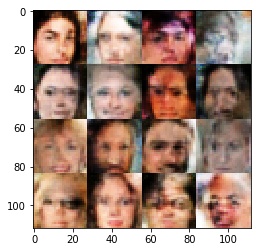

Epoch 0/1... Discriminator Loss: 0.4451... Generator Loss: 1.3542
Epoch 0/1... Discriminator Loss: 0.4781... Generator Loss: 3.7305
Epoch 0/1... Discriminator Loss: 0.7414... Generator Loss: 3.1095
Epoch 0/1... Discriminator Loss: 0.0689... Generator Loss: 3.9703
Epoch 0/1... Discriminator Loss: 0.2635... Generator Loss: 1.9585


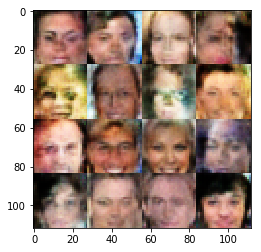

Epoch 0/1... Discriminator Loss: 0.3320... Generator Loss: 1.8518
Epoch 0/1... Discriminator Loss: 0.0824... Generator Loss: 3.8587
Epoch 0/1... Discriminator Loss: 0.2120... Generator Loss: 2.0548
Epoch 0/1... Discriminator Loss: 0.1503... Generator Loss: 2.6799
Epoch 0/1... Discriminator Loss: 0.1370... Generator Loss: 2.8781


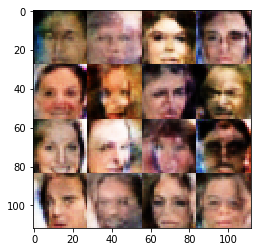

Epoch 0/1... Discriminator Loss: 0.1870... Generator Loss: 2.0326
Epoch 0/1... Discriminator Loss: 0.0876... Generator Loss: 3.9336
Epoch 0/1... Discriminator Loss: 0.1273... Generator Loss: 2.7995
Epoch 0/1... Discriminator Loss: 0.2502... Generator Loss: 1.8028
Epoch 0/1... Discriminator Loss: 0.0711... Generator Loss: 5.8069


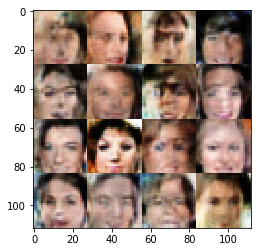

Epoch 0/1... Discriminator Loss: 1.3647... Generator Loss: 0.4823
Epoch 0/1... Discriminator Loss: 1.0493... Generator Loss: 1.4667
Epoch 0/1... Discriminator Loss: 0.6102... Generator Loss: 1.6176
Epoch 0/1... Discriminator Loss: 0.5726... Generator Loss: 1.9905
Epoch 0/1... Discriminator Loss: 1.3794... Generator Loss: 0.4208


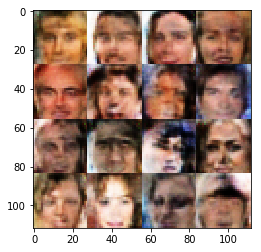

Epoch 0/1... Discriminator Loss: 0.4483... Generator Loss: 1.8395
Epoch 0/1... Discriminator Loss: 0.6082... Generator Loss: 1.2434
Epoch 0/1... Discriminator Loss: 0.6109... Generator Loss: 1.1499
Epoch 0/1... Discriminator Loss: 2.4064... Generator Loss: 0.1364
Epoch 0/1... Discriminator Loss: 0.7696... Generator Loss: 0.9744


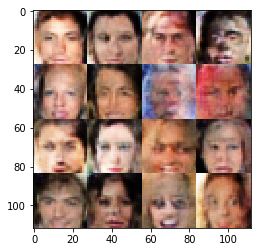

Epoch 0/1... Discriminator Loss: 0.6724... Generator Loss: 0.9890
Epoch 0/1... Discriminator Loss: 0.2056... Generator Loss: 2.7096
Epoch 0/1... Discriminator Loss: 0.5160... Generator Loss: 1.1245
Epoch 0/1... Discriminator Loss: 0.5832... Generator Loss: 2.0090
Epoch 0/1... Discriminator Loss: 0.7180... Generator Loss: 0.8773


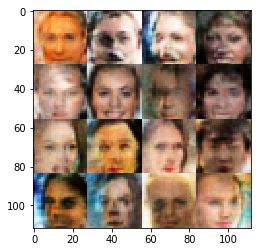

Epoch 0/1... Discriminator Loss: 1.0274... Generator Loss: 2.2193
Epoch 0/1... Discriminator Loss: 0.6780... Generator Loss: 1.0006
Epoch 0/1... Discriminator Loss: 0.2556... Generator Loss: 2.0981
Epoch 0/1... Discriminator Loss: 0.1460... Generator Loss: 2.4922
Epoch 0/1... Discriminator Loss: 2.2321... Generator Loss: 0.1598


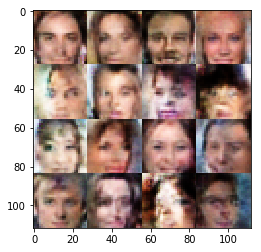

Epoch 0/1... Discriminator Loss: 0.7002... Generator Loss: 1.8751
Epoch 0/1... Discriminator Loss: 0.1245... Generator Loss: 4.3487
Epoch 0/1... Discriminator Loss: 0.1353... Generator Loss: 2.8946
Epoch 0/1... Discriminator Loss: 0.9794... Generator Loss: 0.7469
Epoch 0/1... Discriminator Loss: 0.7652... Generator Loss: 0.9120


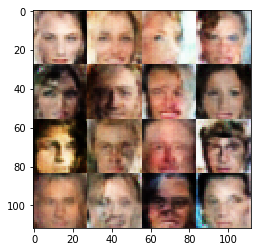

Epoch 0/1... Discriminator Loss: 0.2011... Generator Loss: 2.3278
Epoch 0/1... Discriminator Loss: 0.8750... Generator Loss: 0.7077
Epoch 0/1... Discriminator Loss: 0.0990... Generator Loss: 4.7674
Epoch 0/1... Discriminator Loss: 0.0797... Generator Loss: 5.2824
Epoch 0/1... Discriminator Loss: 0.0575... Generator Loss: 5.6054


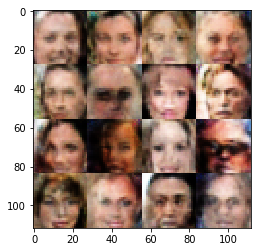

Epoch 0/1... Discriminator Loss: 0.1148... Generator Loss: 4.8715
Epoch 0/1... Discriminator Loss: 0.0500... Generator Loss: 4.7270
Epoch 0/1... Discriminator Loss: 0.0530... Generator Loss: 4.8467
Epoch 0/1... Discriminator Loss: 0.1524... Generator Loss: 2.5135
Epoch 0/1... Discriminator Loss: 0.7038... Generator Loss: 0.8983


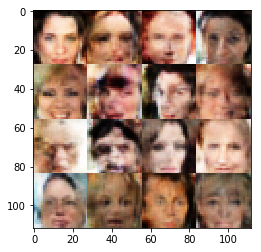

Epoch 0/1... Discriminator Loss: 0.1135... Generator Loss: 2.7599
Epoch 0/1... Discriminator Loss: 0.3352... Generator Loss: 1.7392


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.